<a href="https://colab.research.google.com/github/SChoi005/Data-Science/blob/main/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network
* Data Set : MNIST
* Activation function
  * Linear function : step function
  * Non-linear function : sigmoid, ReLU 
* Activation function at Output layer
  * Classification : Softmax
  * Regression : Identity Function
* Loss Function
  * Sum of Squares for Error (SSE)
  * Cross Entropy Error (CEE)
* Numerical Differentiation
  * Gradient Descent Method

In [61]:
import numpy as np
import matplotlib.pyplot as plt

## Step Function Implement

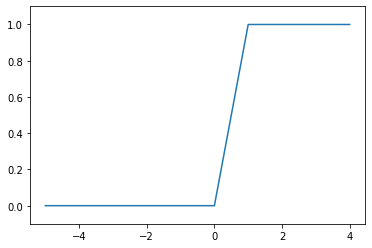

In [62]:
def step_function(x):
  return np.array(x > 0, dtype=np.int32)

x = np.arange(-5.0, 5.0, 1.0)
y = step_function(x)

plt.plot(x, y)
plt.ylim(-0.1, 1.1)
plt.show()

## Sigmoid Function Implement

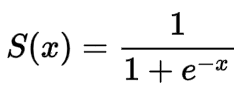

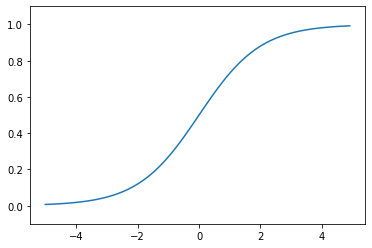

In [63]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.arange(-5.0, 5.0, 0.1)
y = sigmoid(x)

plt.plot(x, y)
plt.ylim(-0.1, 1.1)
plt.show()


## ReLu Function Implement

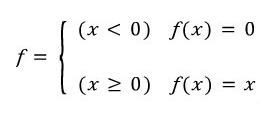

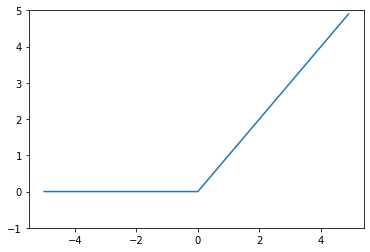

In [64]:
def relu(x):
  return np.maximum(0, x)

x = np.arange(-5.0, 5.0, 0.1)
y = relu(x)

plt.plot(x, y)
plt.ylim(-1, 5)
plt.show()


## Softmax Function


In [65]:
def softmax(a):
  # prevent overflow
  c = np.max(a)
  exp_a = np.exp(a - c)

  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a
  
  return y

a = np.array([3.0, 2.9, 4.0])
y = softmax(a)

print(y)
np.sum(y)

[0.21630418 0.19572011 0.58797571]


1.0

## Implement Neural Network : MNIST

### Forward propagation

In [66]:
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from PIL import Image
import pickle


def get_data():
  # flatten : true -> 28 X 28 X 1 => 784, false(default) -> 28 X 28 X 1 
  # normalize : true -> normalize from 0.0 to 1.0 by dividing values into 255
  # one_hot_label : true -> It makes t_train, t_test one_hot_label

  (x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=True, one_hot_label=False)
  return x_test, t_test

def init_network():
  with open("./dataset/sample_weight.pkl", "rb") as f:
    network = pickle.load(f)

  return network

def predict(network, x):
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']

  a1 = np.dot(x, W1) + b1
  z1 = sigmoid(a1)
  a2 = np.dot(z1, W2) + b2
  z2 = sigmoid(a2)
  a3 = np.dot(z2, W3) + b3
  y = softmax(a3)

  return y



In [67]:
x, t = get_data()
network = init_network()

accuracy_cnt = 0
for i in range(len(x)):
  y = predict(network, x[i])
  p = np.argmax(y)
  if p == t[i]:
    accuracy_cnt += 1

print("Accuracy : " + str(float(accuracy_cnt)/ len(x)))



Accuracy : 0.9352


### Using Batch

In [68]:
batch_size = 100
accuracy_cnt = 0

for i in range(0, len(x), batch_size):
  x_batch = x[i:i+batch_size]
  y_batch = predict(network, x_batch)

  p = np.argmax(y_batch, axis=1)

  accuracy_cnt += np.sum(p == t[i:i+batch_size])

print("Accuracy : " + str(float(accuracy_cnt)/ len(x)))

Accuracy : 0.9352


## Neural Network Learning

### Loss Function

#### Sum of Squares for Error
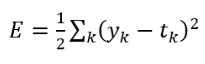

In [69]:
def sum_squares_error(y, t):
  return 0.5 * np.sum((y-t)**2)


t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # one-hot incoding
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0] 

sum_squares_error(np.array(y), np.array(t))

0.09750000000000003

#### Cross Entropy Error
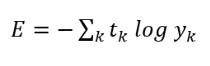

In [70]:
def cross_entropy_error(y, t):
  delta = 1e-7  # Prevent negative infinity
  return -np.sum(t * np.log(y + delta))

t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # one-hot incoding
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0] 

cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

#### Mini-batch for Cross Entropy Error
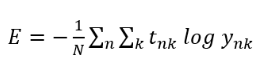

In [71]:
def cross_entropy_error_for_minibatch(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  batch_size = y.shape[0]
  return -np.sum(t * np.log(y + 1e-7)) / batch_size

### Numerical Differentiation

In [72]:
def numerical_gradient_1d(f, x):
  h = 1e-4 # 0.0001
  grad = np.zeros_like(x) # create a array like same x.shape

  for idx in range(x.size):
    tmp_val = x[idx]
    # f(x+h)
    x[idx] = tmp_val + h
    fxh1 = f(x)

    # f(x-h)
    x[idx] = tmp_val - h
    fxh2 = f(x)

    grad[idx] = (fxh1 - fxh2) / (2*h)
    x[idx] = tmp_val # restore value



  return grad

In [73]:
def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = numerical_gradient_1d(f, x)
        
        return grad

#### Gradient Descent Method
* η : Learning Rate
  * Be set to specific value in advance

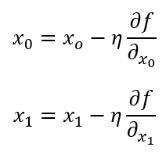

In [74]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
  x= init_x

  for i in range(step_num):
    grad = numerical_gradient_1d(f, x)
    x -= lr * grad
  return x

### Two Layers Net 

In [75]:
class TwoLayersNet :
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def predict(self, x):
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = sigmoid(a2)

    return y

  def loss(self, x, t):
    y = self.predict(x)

    return cross_entropy_error_for_minibatch(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])

    return accuracy

  def numerical_gradient(self, x, t):
    loss_W = lambda W : self.loss(x,t)

    grads = {}
    grads['W1'] = numerical_gradient_2d(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient_2d(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient_2d(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient_2d(loss_W, self.params['b2'])

    return grads


In [57]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

# hyperparameter
iters_num = 10
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayersNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
  # Get mini-batch
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  # calculate gradient
  grad = network.numerical_gradient(x_batch, t_batch)

  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)


In [58]:
print(train_loss_list)

[0.6552515065982943, 0.6255495955152992, 0.5968934032825703, 0.570021934114339, 0.5433934549465248, 0.5186551836782958, 0.497761891450379, 0.47433306194949654, 0.45513821930225185, 0.4363615089619837]


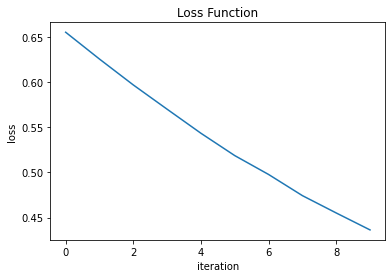

In [77]:
plt.plot(np.arange(iters_num), train_loss_list)
plt.title('Loss Function')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()